# 22. Stackingアンサンブル - メタ学習 (Stacking Ensemble - Meta Learning)

## 概要
複数のモデルを組み合わせて最強の予測モデルを構築する手法を学びます。

## 学習目標
- アンサンブル学習の種類を理解できる
- Stackingの仕組みを理解できる
- 多層Stackingを実装できる
- Out-of-Foldの重要性を理解できる
- 本番環境でStackingを実装できる

In [1]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer, make_classification
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression, Ridge, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    VotingClassifier, StackingClassifier
)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# 設定
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
np.random.seed(42)

## 1. アンサンブル学習とは

### 「三人寄れば文殊の知恵」

複数のモデルを組み合わせることで、単一モデルより高い性能を達成します。

### アンサンブルの種類

1. **Bagging（バギング）**
   - データをランダムサンプリング
   - 並列に学習
   - 多数決や平均で統合
   - 例: Random Forest

2. **Boosting（ブースティング）**
   - 逐次的に学習
   - 前のモデルの誤りを修正
   - 加重平均で統合
   - 例: Gradient Boosting、XGBoost

3. **Stacking（スタッキング）**
   - 複数の異なるモデルを使用
   - メタモデルで統合
   - 最も柔軟で強力
   - Kaggleで人気

## 2. Stackingの仕組み

### 基本構造

```
入力データ
    ↓
┌────────┬────────┬────────┐
│Model 1 │Model 2 │Model 3 │ ← Base Models (Level 0)
└────────┴────────┴────────┘
    ↓        ↓        ↓
  pred1    pred2    pred3
    └────────┴────────┘
           ↓
    ┌──────────┐
    │Meta Model│ ← Meta Learner (Level 1)
    └──────────┘
         ↓
    最終予測
```

### 重要なポイント

1. **多様性**
   - 異なるタイプのモデルを使う
   - 異なる特徴量セットを使う
   - 異なるハイパーパラメータを使う

2. **Out-of-Fold予測**
   - 訓練データの過学習を防ぐ
   - K-Foldで予測を生成
   - メタモデルの汎化性能を保つ

## 3. データ準備

In [2]:
# データセット読み込み
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"訓練データ: {X_train.shape}")
print(f"テストデータ: {X_test.shape}")
print(f"クラス分布: {np.bincount(y_train)}")

訓練データ: (455, 30)
テストデータ: (114, 30)
クラス分布: [170 285]


## 4. Voting vs Stacking

### まずはVotingから

In [3]:
# ベースモデルの定義
models = {
    'Logistic': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# 個別モデルの性能
print("個別モデルの性能:")
print("=" * 50)
individual_scores = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    individual_scores[name] = scores.mean()
    print(f"{name:20s}: {scores.mean():.4f} (+/- {scores.std():.4f})")

個別モデルの性能:


Logistic            : 0.9429 (+/- 0.0146)


RandomForest        : 0.9538 (+/- 0.0235)


GradientBoosting    : 0.9582 (+/- 0.0108)
SVM                 : 0.9099 (+/- 0.0290)


In [4]:
# Voting Classifier
voting_hard = VotingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    voting='hard'
)

voting_soft = VotingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    voting='soft'
)

# 評価
print("\nVoting Classifier:")
print("=" * 50)
for name, model in [('Hard Voting', voting_hard), ('Soft Voting', voting_soft)]:
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name:20s}: {scores.mean():.4f} (+/- {scores.std():.4f})")


Voting Classifier:


Hard Voting         : 0.9560 (+/- 0.0139)


Soft Voting         : 0.9626 (+/- 0.0149)


### Stacking Classifier

In [5]:
# Stacking Classifier
stacking = StackingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5  # Out-of-fold予測用
)

# 評価
scores = cross_val_score(stacking, X_train, y_train, cv=5, scoring='accuracy')
print("\nStacking Classifier:")
print("=" * 50)
print(f"CV Score: {scores.mean():.4f} (+/- {scores.std():.4f})")

# テストデータでの評価
stacking.fit(X_train, y_train)
test_score = stacking.score(X_test, y_test)
print(f"Test Score: {test_score:.4f}")


Stacking Classifier:
CV Score: 0.9604 (+/- 0.0179)


Test Score: 0.9649


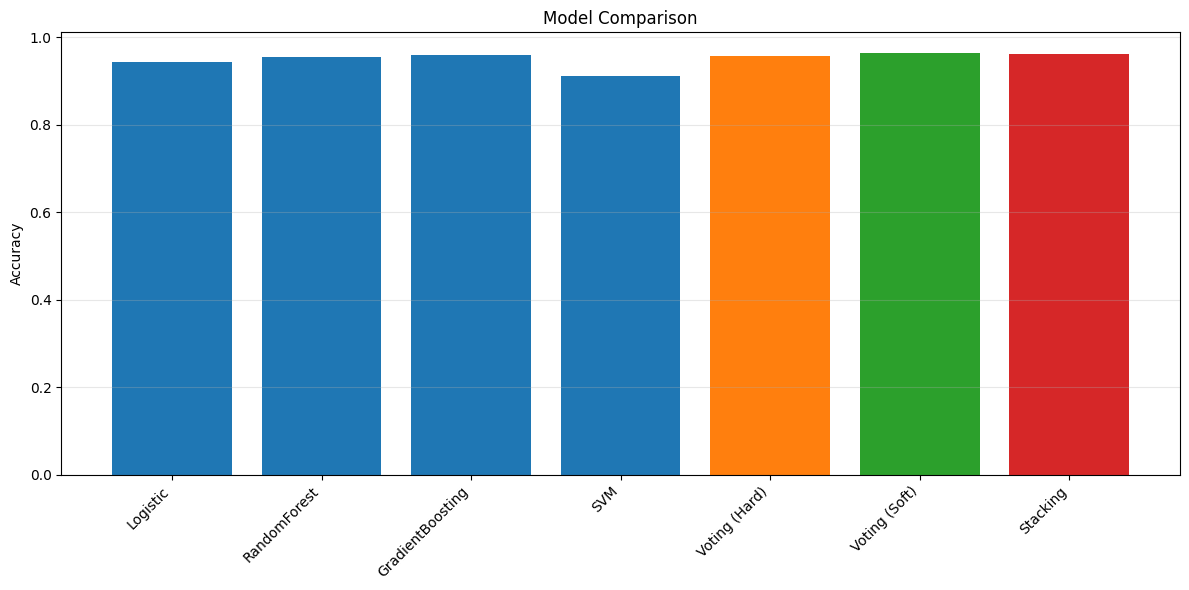


ベストモデル: Voting (Soft)
スコア: 0.9626


In [6]:
# 結果の比較
all_scores = {**individual_scores,
              'Voting (Hard)': cross_val_score(voting_hard, X_train, y_train, cv=5).mean(),
              'Voting (Soft)': cross_val_score(voting_soft, X_train, y_train, cv=5).mean(),
              'Stacking': scores.mean()}

# 可視化
plt.figure(figsize=(12, 6))
plt.bar(range(len(all_scores)), list(all_scores.values()), color=['C0']*4 + ['C1', 'C2', 'C3'])
plt.xticks(range(len(all_scores)), list(all_scores.keys()), rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nベストモデル:", max(all_scores, key=all_scores.get))
print(f"スコア: {max(all_scores.values()):.4f}")

## 5. カスタムStacking実装

### Out-of-Fold予測の仕組み

より細かい制御のため、自分でStackingを実装します。

In [7]:
def create_oof_predictions(models, X_train, y_train, X_test, n_folds=5):
    """
    Out-of-Fold予測を生成
    
    Parameters:
    -----------
    models : dict
        モデル名とモデルのディクショナリ
    X_train, y_train : array
        訓練データ
    X_test : array
        テストデータ
    n_folds : int
        Fold数
    
    Returns:
    --------
    train_meta : array
        訓練用メタ特徴量
    test_meta : array
        テスト用メタ特徴量
    """
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # メタ特徴量の初期化
    train_meta = np.zeros((X_train.shape[0], len(models)))
    test_meta = np.zeros((X_test.shape[0], len(models)))
    
    for i, (name, model) in enumerate(models.items()):
        print(f"Processing {name}...")
        
        test_preds_folds = []
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
            # Foldごとに学習
            X_tr, X_val = X_train[train_idx], X_train[val_idx]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]
            
            # 学習
            model.fit(X_tr, y_tr)
            
            # Out-of-fold予測（訓練データ）
            train_meta[val_idx, i] = model.predict_proba(X_val)[:, 1]
            
            # テストデータ予測
            test_preds_folds.append(model.predict_proba(X_test)[:, 1])
        
        # テストデータ予測の平均
        test_meta[:, i] = np.mean(test_preds_folds, axis=0)
    
    return train_meta, test_meta

In [8]:
# Out-of-fold予測の生成
print("Out-of-Fold予測を生成中...")
print("=" * 50)

train_meta, test_meta = create_oof_predictions(
    models, X_train, y_train, X_test, n_folds=5
)

print(f"\n訓練メタ特徴量: {train_meta.shape}")
print(f"テストメタ特徴量: {test_meta.shape}")

# メタ特徴量の確認
meta_df = pd.DataFrame(train_meta, columns=models.keys())
print("\nメタ特徴量のサンプル:")
print(meta_df.head())

Out-of-Fold予測を生成中...
Processing Logistic...


Processing RandomForest...


Processing GradientBoosting...


Processing SVM...

訓練メタ特徴量: (455, 4)
テストメタ特徴量: (114, 4)

メタ特徴量のサンプル:
   Logistic  RandomForest  GradientBoosting       SVM
0  0.999377          1.00          0.999762  0.991428
1  0.001439          0.00          0.000165  0.002642
2  0.999604          0.99          0.999738  0.968252
3  0.986828          0.94          0.999443  0.856341
4  0.999119          1.00          0.999777  0.980630


In [9]:
# メタモデルの学習
meta_model = LogisticRegression(max_iter=1000, random_state=42)
meta_model.fit(train_meta, y_train)

# 予測
train_pred = meta_model.predict(train_meta)
test_pred = meta_model.predict(test_meta)

train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

print(f"訓練精度: {train_accuracy:.4f}")
print(f"テスト精度: {test_accuracy:.4f}")

# メタモデルの係数（各ベースモデルの重要度）
print("\nメタモデルの係数（ベースモデルの重み）:")
for name, coef in zip(models.keys(), meta_model.coef_[0]):
    print(f"  {name:20s}: {coef:.4f}")

訓練精度: 0.9692
テスト精度: 0.9561

メタモデルの係数（ベースモデルの重み）:
  Logistic            : 2.6221
  RandomForest        : 2.4785
  GradientBoosting    : 2.1724
  SVM                 : 0.8007


## 6. 多層Stacking

### Level 2のStacking

さらに性能を上げるため、複数層のStackingを構築します。

In [10]:
# Level 0: より多様なモデル
level0_models = {
    'LR': LogisticRegression(max_iter=1000, random_state=42),
    'RF1': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    'RF2': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=43),
    'GB1': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    'GB2': GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, random_state=43),
    'MLP': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

# Level 1: Level 0の予測を統合
level1_models = {
    'LR2': LogisticRegression(max_iter=1000, random_state=44),
    'RF': RandomForestClassifier(n_estimators=50, random_state=42)
}

print("多層Stacking構築中...")
print("=" * 50)

# Level 0の予測
train_level0, test_level0 = create_oof_predictions(
    level0_models, X_train, y_train, X_test, n_folds=5
)

# Level 1の予測
train_level1, test_level1 = create_oof_predictions(
    level1_models, train_level0, y_train, test_level0, n_folds=5
)

# 最終メタモデル
final_meta = LogisticRegression(max_iter=1000, random_state=42)
final_meta.fit(train_level1, y_train)

final_pred = final_meta.predict(test_level1)
final_accuracy = accuracy_score(y_test, final_pred)

print(f"\n多層Stackingテスト精度: {final_accuracy:.4f}")


多層Stacking構築中...
Processing LR...


Processing RF1...


Processing RF2...


Processing GB1...


Processing GB2...


Processing MLP...


Processing LR2...
Processing RF...

多層Stackingテスト精度: 0.9649


## 7. 本番実装

### 再利用可能なStackingクラス

In [11]:
class CustomStacking:
    """
    カスタムStackingクラス
    """
    def __init__(self, base_models, meta_model, n_folds=5, use_proba=True):
        """
        Parameters:
        -----------
        base_models : list of tuples
            (name, model)のリスト
        meta_model : estimator
            メタモデル
        n_folds : int
            Fold数
        use_proba : bool
            確率予測を使うか（分類の場合）
        """
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        self.use_proba = use_proba
        self.trained_base_models = []
    
    def fit(self, X, y):
        """学習"""
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        
        # メタ特徴量の初期化
        meta_features = np.zeros((X.shape[0], len(self.base_models)))
        
        # 各ベースモデルの学習
        for i, (name, model) in enumerate(self.base_models):
            print(f"Training {name}...")
            
            for train_idx, val_idx in kfold.split(X):
                X_tr, X_val = X[train_idx], X[val_idx]
                y_tr = y[train_idx]
                
                # クローンして学習
                from sklearn.base import clone
                model_clone = clone(model)
                model_clone.fit(X_tr, y_tr)
                
                # Out-of-fold予測
                if self.use_proba and hasattr(model_clone, 'predict_proba'):
                    meta_features[val_idx, i] = model_clone.predict_proba(X_val)[:, 1]
                else:
                    meta_features[val_idx, i] = model_clone.predict(X_val)
            
            # 全データで最終学習
            model.fit(X, y)
            self.trained_base_models.append((name, model))
        
        # メタモデルの学習
        print("Training meta model...")
        self.meta_model.fit(meta_features, y)
        
        return self
    
    def predict(self, X):
        """予測"""
        # ベースモデルの予測
        meta_features = np.zeros((X.shape[0], len(self.trained_base_models)))
        
        for i, (name, model) in enumerate(self.trained_base_models):
            if self.use_proba and hasattr(model, 'predict_proba'):
                meta_features[:, i] = model.predict_proba(X)[:, 1]
            else:
                meta_features[:, i] = model.predict(X)
        
        # メタモデルで最終予測
        return self.meta_model.predict(meta_features)
    
    def predict_proba(self, X):
        """確率予測"""
        meta_features = np.zeros((X.shape[0], len(self.trained_base_models)))
        
        for i, (name, model) in enumerate(self.trained_base_models):
            if self.use_proba and hasattr(model, 'predict_proba'):
                meta_features[:, i] = model.predict_proba(X)[:, 1]
            else:
                meta_features[:, i] = model.predict(X)
        
        return self.meta_model.predict_proba(meta_features)

In [12]:
# カスタムStackingの使用
custom_stacking = CustomStacking(
    base_models=[(name, model) for name, model in models.items()],
    meta_model=LogisticRegression(max_iter=1000, random_state=42),
    n_folds=5
)

print("カスタムStacking学習中...")
print("=" * 50)
custom_stacking.fit(X_train, y_train)

# 予測と評価
y_pred_custom = custom_stacking.predict(X_test)
custom_accuracy = accuracy_score(y_test, y_pred_custom)

print(f"\nカスタムStackingテスト精度: {custom_accuracy:.4f}")
print("\n分類レポート:")
print(classification_report(y_test, y_pred_custom, target_names=cancer.target_names))

カスタムStacking学習中...
Training Logistic...


Training RandomForest...


Training GradientBoosting...


Training SVM...
Training meta model...

カスタムStackingテスト精度: 0.9561

分類レポート:
              precision    recall  f1-score   support

   malignant       0.95      0.93      0.94        42
      benign       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



## 8. まとめ

### 本ノートブックで学んだこと

1. **アンサンブルの種類**
   - Bagging、Boosting、Stacking
   - それぞれの特徴と使い分け

2. **Stackingの基礎**
   - ベースモデルとメタモデル
   - 多様性の重要性
   - Voting vs Stacking

3. **Out-of-Fold予測**
   - 過学習の防止
   - K-Foldによる予測生成
   - 汎化性能の保持

4. **カスタム実装**
   - 柔軟な制御
   - 多層Stacking
   - 再利用可能なクラス

5. **本番実装**
   - CustomStackingクラス
   - fit/predict インターフェース
   - プロダクション対応

### Stackingを使うべきとき

- ✅ 最高の性能が必要（Kaggleなど）
- ✅ 計算リソースに余裕がある
- ✅ 複数の強力なベースモデルがある
- ✅ モデルの多様性を活かしたい

### 注意点

- ⚠️ 計算コストが高い
- ⚠️ 解釈性が低い
- ⚠️ 過学習のリスク（Out-of-Fold必須）
- ⚠️ デプロイの複雑さ

### 次のステップ

- 実際のKaggleコンペでStackingを活用
- より高度なStacking戦略を探求
- ニューラルネットワークとの組み合わせ
- AutoMLツールの活用